### **Plotting ROS Data with bagpy**
---
Greetings, MEAM 620! In this document, we will walk through parsing the `.bag` files you collected during the in person Crazyflie labs. We will discuss installing `bagpy`, extracting all the relevant data, and how to plot that data with brief examples.

More information about `bagpy` can be found [here](https://jmscslgroup.github.io/bagpy/about.html), and the official Github repo can be found [here](https://github.com/jmscslgroup/bagpy).

#### **Installation and Imports**
If you are working on Linux or Mac, you can install `bagpy` through `pip`, as in the following command.

Unfortunately `bagpy` is not officially supported for Windows. You can probably install it, but there is no guarantee installation will be seamless. Further, any bugs you come across may not have a fix. We recommend that if you are using Windows you should try using Google Colab instead, as is done so in this document.


In [ ]:
!pip install -U bagpy --quiet

*The exclamation point is only required when working here in Google Colab or Jupyter notebooks. Similarly, the extra argument `--quiet` is only there to suppress the output of this line so it doesn't get in the way.*

Other imports include `matplotlib`, `numpy`, `pandas`, and `scipy` for the convenient Rotations library. 

In [ ]:
!pip install matplotlib numpy scipy pandas --quiet

In [ ]:
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
import bagpy
from bagpy import bagreader   # this contains a class that does all the hard work of reading bag files
from google.colab import files  # only necessary if you are using Google Colab like me

#### **Extracting Data**
Next you'll want to read in your bag file. This is where `bagpy` comes into play! 

See below for a list of all the relevant data from your bag file.

In [ ]:
bag_name = "really_good_data.bag"   # It's easiest if all the bag files are in the same directory as this script. 

In [ ]:
b = bagreader(bag_name)   # This creates an object that we name 'b' that contains all the information from your bag file

[INFO]  Data folder really_good_data already exists. Not creating.


In [ ]:
csvfiles = []     # To avoid mixing up topics, we save each topic as an individual csv file, since some topics might have the same headers!
for t in b.topics:
    data = b.message_by_topic(t)
    csvfiles.append(data)


state = pd.read_csv(csvfiles[0])   # The topic "odom" contains all the state information we need

vicon_time = state['Time'] - b.start_time   # Here we are extracting time and subtracting the start time of the .bag file

# Position
x = state['pose.pose.position.x']
y = state['pose.pose.position.y']
z = state['pose.pose.position.z']

# Velocity
xdot = state['twist.twist.linear.x']
ydot = state['twist.twist.linear.y']
zdot = state['twist.twist.linear.z']

# Angular Velocity (w.r.t. body frames x, y, and z)
wx = state['twist.twist.angular.x']
wy = state['twist.twist.angular.y']
wz = state['twist.twist.angular.z']

# Orientation (measured as a unit quaternion)
qx = state['pose.pose.orientation.x']
qy = state['pose.pose.orientation.y']
qz = state['pose.pose.orientation.z']
qw = state['pose.pose.orientation.w']

# If you want to use Rotation, these lines might be useful
q = np.vstack((qx,qy,qz,qw)).T      # Stack the quaternions, shape -> (N,4)
rot = Rotation.from_quat(q[0,:])    # This should be familiar from the simulator

Great, now we've extracted our state from `bagreader`, but we have to handle the control outputs since they aren't the same as your simulator. 

Recall from lab that the Crazyflie is not actually receiving individual motor commands--a lower level controller running onboard the quadcopter is regulating the attitude instead. 

So what ROS is recording is actually the commands we send to the Crazyflie: `cmd_q` and `cmd_thrust` from your controller, with a little pre processing of these values to be compatible with the Crazyflie. Specifically, the Crazyflie requires inputs of a thrust in terms of Pulse Width Modulation (PWM), and attitude in terms of Euler ZYX angles. 

In [ ]:
control = pd.read_csv(csvfiles[1])   # The topic "so3cmd_to_crazyflie/cmd_vel_fast" has our control inputs

# Different topics publish at different rates and times... we need to make sure the times is synced up between topics
control_time = control['Time'] - b.start_time

# Coefficients below are used to convert thrust PWM (sent to Crazyflie) into Newtons (what your controller computes)
c1 = -0.6709 
c2 = 0.1932
c3 = 13.0652
cmd_thrust = (((control['linear.z']/60000 - c1) / c2)**2 - c3)/1000*9.81

# Orientation is sent to the Crazyflie as Euler angles (pitch and roll, specifically)
roll = control['linear.x']
pitch = control['linear.y']
yaw = np.zeros(pitch.shape)  # Here we assume 0 yaw.
cmd_q = Rotation.from_euler('zyx', np.transpose([yaw,roll,pitch]), degrees=True).as_quat()  # Generate quaternions from Euler angles

#### **Plotting Your Data**
Once you've extracted your data, it's pretty straightforward to plot that data using `matplotlib`!

Here we will use position and velocity as a first example, but remember you also have access to the orientation (as a quaternion) which we will demonstrate below.

Text(0.5, 0, 'time, s')

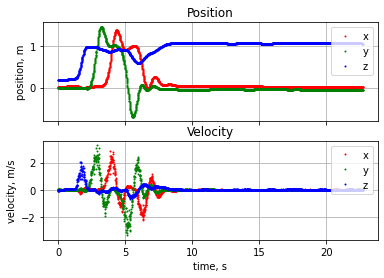

In [ ]:
# It's often useful to save the objects associated with a figure and its axes
(fig1, axes) = plt.subplots(nrows=2, ncols=1, sharex=True, num='Position vs Time')

ax = axes[0]    # Select the first plot

# You can plot using multiple lines if you want it to be readable
ax.plot(vicon_time, x, 'r.', markersize=2)   
ax.plot(vicon_time, y, 'g.', markersize=2)
ax.plot(vicon_time, z, 'b.', markersize=2)
ax.legend(('x', 'y', 'z'), loc='upper right')   # Set a legend
ax.set_ylabel('position, m')                    # Set a y label
ax.grid('major')                                # Put on a grid
ax.set_title('Position')                        # Plot title

ax = axes[1]    # Select the second plot

# Or to be more efficient you can plot everything with one line...
ax.plot(vicon_time, xdot, 'r.', vicon_time, ydot, 'g.', vicon_time, zdot, 'b.', markersize=2)
ax.legend(('x','y','z'), loc='upper right')
ax.set_ylabel('velocity, m/s')
ax.grid('major')
ax.set_title('Velocity')
ax.set_xlabel("time, s")

*Remark: This is not a good plot! There's a lot of wasted plot here where the quadcopter is just hovering. Remember you should only plot the interesting bits of your data.*


Now let's plot the control commands. 

Text(0.5, 1.0, 'Body Rates')

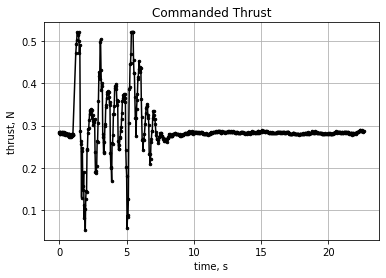

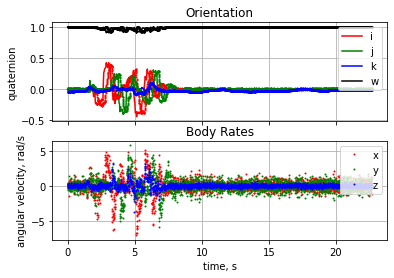

In [ ]:
# Commands vs. Time
(fig2, axes) = plt.subplots(nrows=1, ncols=1, sharex=True, num='Commands vs Time')
ax = axes
ax.plot(control_time, cmd_thrust, 'k.-', markersize=5)
ax.set_ylabel('thrust, N')
ax.set_xlabel('time, s')
ax.grid('major')
ax.set_title('Commanded Thrust')

# Orientation and Angular Velocity vs. Time
(fig3, axes) = plt.subplots(nrows=2, ncols=1, sharex=True, num='Orientation vs Time')

ax = axes[0]
ax.plot(control_time, cmd_q[:,0], 'r', control_time, cmd_q[:,1], 'g',
        control_time, cmd_q[:,2], 'b', control_time, cmd_q[:,3], 'k')
ax.plot(vicon_time, q[:,0], 'r.',  vicon_time, q[:,1], 'g.',
        vicon_time, q[:,2], 'b.',  vicon_time, q[:,3],'k.', markersize=2)
ax.legend(('i', 'j', 'k', 'w'), loc='upper right')
ax.set_ylabel('quaternion')
ax.grid('major')
ax.set_title('Orientation')

ax = axes[1]
ax.plot(vicon_time, wx, 'r.', vicon_time, wy, 'g.', vicon_time, wz, 'b.',markersize=2)
ax.legend(('x', 'y', 'z'), loc='upper right')
ax.set_ylabel('angular velocity, rad/s')
ax.set_xlabel('time, s')
ax.grid('major')
ax.set_title('Body Rates')

*These are not great plots. Remember that it is up to you and your group to generate plots that are readable and interpretable by the reader.*

Lastly, let's consider how to plot the 3D position of the quadcopter. It's a little different that the previous examples. Here's a brief example doing so. 

Text(0.5, 0.92, 'Crazyflie Trajectory')

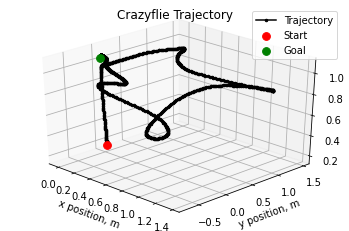

In [ ]:
fig4 = plt.figure()
ax = fig4.add_subplot(projection='3d')

ax.view_init(elev=30, azim=-45)
ax.set_xlabel('x position, m')
ax.set_ylabel('y position, m')
ax.set_zlabel('z position, m')
ax.plot3D(x,y,z,'k.-',markersize=5)
ax.scatter3D(x[0],y[0],z[0], marker='o', c='r', s=60)
ax.scatter3D(x.iloc[-1],y.iloc[-1],z.iloc[-1], marker='o', c='g', s=60)
ax.legend(('Trajectory','Start','Goal'))
ax.set_title("Crazyflie Trajectory")

*You might recognize this path as a quadcopter doing a pretty poor job at tracking `evaluation.json` from the first lab.*

#### **Saving Figures**
Once you've generated figures that you would like to put in your report, you can do so using `matplotlib.pyplot.savefig`. Example below: 

In [ ]:
fig3.savefig('awesome_figure_for_my_report.pdf',bbox_inches='tight')

#### **Plotting Waypoints and Desired Trajectory**
Currently, the `.bag` files do **not** contain the desired trajectory (flat outputs) or the waypoints created by your path planner. This is unfortunate, but it doesn't mean you can't still generate a plot of the 3D environment with your real trajectory on top of it! 

To do so, we currently suggest that you to run the lab maps (provided to you in lab) in simulation using the same controller, planner, and trajectory generator you used for the lab. With this document, you learned how to extract the real trajectory data from your `.bag` files into numpy arrays. You can take those arrays elsewhere, or import arrays containing your simulation results, in order to plot simulated and real trajectories on a single plot.  

